导入库

In [1]:
import gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque

定义Q网络

In [2]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_dim)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

DQN Agent

In [3]:
class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.memory = deque(maxlen=2000)
        self.gamma = 0.99
        self.epsilon = 1.0  # 初始探索率
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 1e-3
        self.batch_size = 64

        self.model = QNetwork(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.MSELoss()
        
    def remember(self, s, a, r, s_, done):
        self.memory.append((s, a, r, s_, done))
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state)
        q_values = self.model(state)
        return torch.argmax(q_values).item()
    
    def replay(self):
        if len(self.memory) < self.batch_size: return
        minibatch = random.sample(self.memory, self.batch_size)
        
        states = torch.FloatTensor([m[0] for m in minibatch])
        actions = torch.LongTensor([m[1] for m in minibatch]).unsqueeze(1)
        rewards = torch.FloatTensor([m[2] for m in minibatch])
        next_states = torch.FloatTensor([m[3] for m in minibatch])
        dones = torch.FloatTensor([float(m[4]) for m in minibatch])
        
        q_values = self.model(states).gather(1, actions).squeeze()
        next_q_values = self.model(next_states).max(1)[0]
        targets = rewards + (1 - dones) * self.gamma * next_q_values
        
        loss = self.loss_fn(q_values, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


环境、训练主循环

In [4]:
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQNAgent(state_dim, action_dim)

episodes = 400
scores = []

for e in range(episodes):
    state = env.reset()
    # For gym>=0.26, env.reset() returns (obs, info), for older versions just obs
    if isinstance(state, tuple):
        state = state[0]
    done = False
    total_reward = 0
    while not done:
        action = agent.act(state)
        step_result = env.step(action)
        # For gym>=0.26, step returns (obs, reward, terminated, truncated, info)
        # For older versions, (obs, reward, done, info)
        if len(step_result) == 5:
            next_state, reward, terminated, truncated, info = step_result
            done = terminated or truncated
        else:
            next_state, reward, done, info = step_result
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        agent.replay()
    scores.append(total_reward)
    if (e+1) % 20 == 0:
        print(f"Episode {e+1}/{episodes}, Score: {total_reward}, Epsilon: {agent.epsilon:.2f}")

C:\Users\spider\AppData\Local\Temp\ipykernel_27628\1338999301.py:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  states = torch.FloatTensor([m[0] for m in minibatch])


Episode 20/400, Score: 22.0, Epsilon: 0.05
Episode 40/400, Score: 125.0, Epsilon: 0.01
Episode 60/400, Score: 95.0, Epsilon: 0.01
Episode 80/400, Score: 289.0, Epsilon: 0.01
Episode 100/400, Score: 227.0, Epsilon: 0.01
Episode 120/400, Score: 417.0, Epsilon: 0.01
Episode 140/400, Score: 500.0, Epsilon: 0.01
Episode 160/400, Score: 96.0, Epsilon: 0.01
Episode 180/400, Score: 90.0, Epsilon: 0.01
Episode 200/400, Score: 324.0, Epsilon: 0.01
Episode 220/400, Score: 500.0, Epsilon: 0.01
Episode 240/400, Score: 500.0, Epsilon: 0.01
Episode 260/400, Score: 500.0, Epsilon: 0.01
Episode 280/400, Score: 290.0, Epsilon: 0.01
Episode 300/400, Score: 500.0, Epsilon: 0.01
Episode 320/400, Score: 182.0, Epsilon: 0.01
Episode 340/400, Score: 145.0, Epsilon: 0.01
Episode 360/400, Score: 206.0, Epsilon: 0.01
Episode 380/400, Score: 41.0, Epsilon: 0.01
Episode 400/400, Score: 278.0, Epsilon: 0.01


训练过程可视化

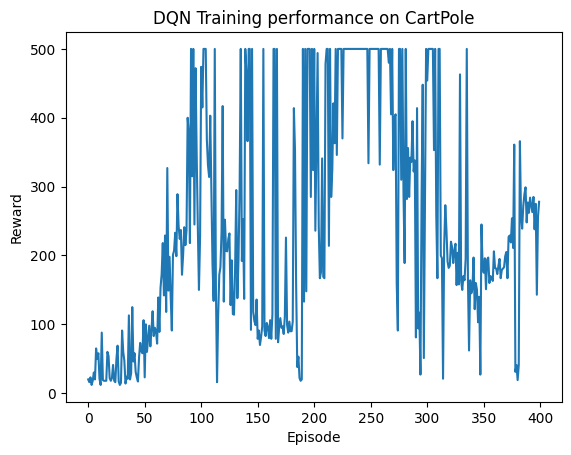

In [5]:
plt.plot(scores)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DQN Training performance on CartPole')
plt.show()

测试智能体控制效果

In [7]:
test_episodes = 5
for i in range(test_episodes):
    state = env.reset()
    # For gym>=0.26, env.reset() returns (obs, info), for older versions just obs
    if isinstance(state, tuple):
        state = state[0]
    done = False
    total_reward = 0
    while not done:
        action = agent.act(state)
        step_result = env.step(action)
        # For gym>=0.26, step returns (obs, reward, terminated, truncated, info)
        # For older versions, (obs, reward, done, info)
        if len(step_result) == 5:
            next_state, reward, terminated, truncated, info = step_result
            done = terminated or truncated
        else:
            next_state, reward, done, info = step_result
        state = next_state
        total_reward += reward
        env.render()
    print(f"Test Episode {i+1}, Score: {total_reward}")
env.close()

Test Episode 1, Score: 500.0
Test Episode 2, Score: 320.0
Test Episode 3, Score: 500.0
Test Episode 4, Score: 433.0
Test Episode 5, Score: 500.0


c:\Users\spider\AppData\Local\Programs\Python\Python312\Lib\site-packages\gym\envs\classic_control\cartpole.py:211: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


定义策略网络

In [8]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        # 输出每个动作的对数概率，用于计算损失
        return torch.log_softmax(self.fc3(x), dim=-1)

实现REINFORCE智能体

In [9]:
class REINFORCEAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = 0.99
        self.learning_rate = 1e-3

        self.policy_network = PolicyNetwork(state_dim, action_dim)
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=self.learning_rate)
        
        self.rewards = []
        self.log_probs = []

    def act(self, state):
        state = torch.FloatTensor(state).unsqueeze(0) # 增加批次维度
        log_probs = self.policy_network(state)
        # 从概率分布中采样动作
        action_distribution = torch.exp(log_probs)
        action = torch.multinomial(action_distribution, 1).item()
        
        # 存储当前动作的对数概率，用于后续梯度计算
        self.log_probs.append(log_probs.squeeze(0)[action])
        return action

    def finish_episode(self):
        # 计算每个时间步的折扣回报 (G_t)
        returns = []
        G = 0
        for r in reversed(self.rewards):
            G = r + self.gamma * G
            returns.insert(0, G)
        
        returns = torch.tensor(returns)
        # 标准化回报，有助于稳定训练
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)

        # 计算策略损失
        policy_loss = []
        for log_prob, G in zip(self.log_probs, returns):
            policy_loss.append(-log_prob * G) # 目标是最大化回报，所以取负号最小化损失
        
        self.optimizer.zero_grad()
        loss = torch.stack(policy_loss).sum() # 累加所有时间步的损失
        loss.backward()
        self.optimizer.step()

        # 清空当前回合的记录
        self.rewards = []
        self.log_probs = []

环境设置与训练主循环

In [10]:
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
reinforce_agent = REINFORCEAgent(state_dim, action_dim)

episodes = 400
reinforce_scores = []

print("Starting REINFORCE training...")
for e in range(episodes):
    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]
    done = False
    total_reward = 0
    while not done:
        action = reinforce_agent.act(state)
        step_result = env.step(action)
        if len(step_result) == 5:
            next_state, reward, terminated, truncated, info = step_result
            done = terminated or truncated
        else:
            next_state, reward, done, info = step_result
        
        reinforce_agent.rewards.append(reward) # 存储奖励
        state = next_state
        total_reward += reward
    
    reinforce_agent.finish_episode() # 回合结束后更新策略
    reinforce_scores.append(total_reward)
    if (e+1) % 20 == 0:
        print(f"REINFORCE Episode {e+1}/{episodes}, Score: {total_reward}")

Starting REINFORCE training...
REINFORCE Episode 20/400, Score: 21.0
REINFORCE Episode 40/400, Score: 10.0
REINFORCE Episode 60/400, Score: 38.0
REINFORCE Episode 80/400, Score: 14.0
REINFORCE Episode 100/400, Score: 25.0
REINFORCE Episode 120/400, Score: 12.0
REINFORCE Episode 140/400, Score: 54.0
REINFORCE Episode 160/400, Score: 51.0
REINFORCE Episode 180/400, Score: 35.0
REINFORCE Episode 200/400, Score: 33.0
REINFORCE Episode 220/400, Score: 17.0
REINFORCE Episode 240/400, Score: 249.0
REINFORCE Episode 260/400, Score: 121.0
REINFORCE Episode 280/400, Score: 123.0
REINFORCE Episode 300/400, Score: 143.0
REINFORCE Episode 320/400, Score: 299.0
REINFORCE Episode 340/400, Score: 133.0
REINFORCE Episode 360/400, Score: 241.0
REINFORCE Episode 380/400, Score: 256.0
REINFORCE Episode 400/400, Score: 479.0


训练过程可视化 (对比DQN)

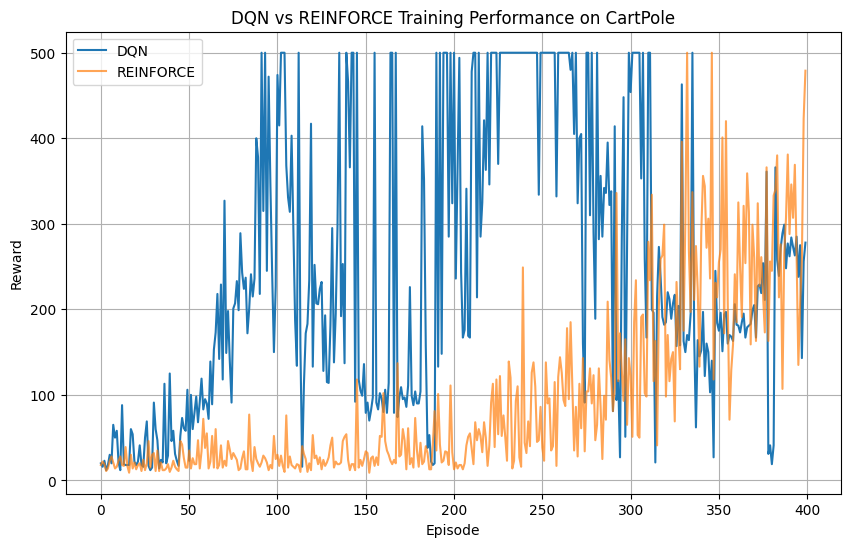

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(scores, label='DQN') # 从DQN实验中获取的scores
plt.plot(reinforce_scores, label='REINFORCE', alpha=0.7)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DQN vs REINFORCE Training Performance on CartPole')
plt.legend()
plt.grid(True)
plt.show()

测试智能体控制效果

In [12]:
test_episodes = 5
print("\nStarting REINFORCE test...")
for i in range(test_episodes):
    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]
    done = False
    total_reward = 0
    while not done:
        # For testing, we typically don't sample, but rather choose the action with highest probability
        # For discrete action space, this means using argmax on the log_softmax output
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad(): # No gradient calculations during testing
            log_probs = reinforce_agent.policy_network(state_tensor)
            action = torch.argmax(log_probs).item()

        step_result = env.step(action)
        if len(step_result) == 5:
            next_state, reward, terminated, truncated, info = step_result
            done = terminated or truncated
        else:
            next_state, reward, done, info = step_result
        state = next_state
        total_reward += reward
        env.render()
    print(f"REINFORCE Test Episode {i+1}, Score: {total_reward}")
env.close()


Starting REINFORCE test...
REINFORCE Test Episode 1, Score: 500.0
REINFORCE Test Episode 2, Score: 500.0
REINFORCE Test Episode 3, Score: 500.0
REINFORCE Test Episode 4, Score: 500.0
REINFORCE Test Episode 5, Score: 500.0
